In [1]:
import networkx as nx
import plotly
import plotly.graph_objs as go
import numpy as np
import string
from networkplotter import NetworkXPlotter

## Defining this stuff

In [2]:
class Node(object):
    def __init__(self, name, value):
        self.name = name
        self.value = value
        self.connections = dict()
    
    def set_connections(self, connections):
        for connection in connections:
            self.connections[connection[1]] = connection[0]
      
    def set_weight(self, connection):
        self.connections[connection[1]] = connection[0]
    
    def set_value(self, value):
        self.value = value
    
    def remove_connection(self, node):
        try:
            self.connections.pop(node)
        except KeyError:
            print("No connection detected")
    
    def __str__(self):
        return self.name
    
class Graph(object):
    def __init__(self, name):
        self.name = name
        self.nodes = []
        self.A = []
        
    def form_subgraphs(self, clusters):
        clusters_keys = list(clusters.keys())
        clusters_values  = list(clusters.values())
        subgraphs = []
        connections = []
        
        for cluster in clusters_keys:
            value = reduce(lambda x, y: x.value + y.value, clusters[cluster]) \
            if len(clusters[cluster]) > 1 else clusters[cluster][0].value 
            
            subgraphs.append(Node(cluster,value))    
        
        for i in range(len(clusters)):
            connections = []
            for j in range(len(clusters)):
                weight = 0
                for node_left in clusters_values[i]:
                    for node_right in node_left.connections.keys():
                        additive = node_left.connections[node_right] if node_right in clusters_values[j] \
                        and not node_right in clusters_values[i] else 0
                        weight += additive
                connections.append([weight, subgraphs[j]])
           
            subgraphs[i].set_connections(connections)
        
        aggregated = Graph('aggregated')
        aggregated.set_nodes(subgraphs)
        return aggregated
    
    def set_nodes(self, nodes):
        self.nodes = nodes
     
    def add_node(self, node):
        self.nodes.append(node)
        
    def remove_node(self, node):
        try:
            self.nodes.remove(node)
        except ValueError:
            print("no node " + str(node) + " in the graph")
    
    def __str__(self):
        return self.name
    
    def form_connection_matrix(self):
        self.A = np.zeros((len(self.nodes), len(self.nodes)))
        for i in range(len(self.nodes)):
            
            connection_nodes = list(self.nodes[i].connections.keys())
            for j in range(len(self.nodes)):
                self.A[i, j] = self.nodes[i].connections[self.nodes[j]] \
                if self.nodes[j] in connection_nodes else 0
        
        return self.A
    
    def update_values(self, nodes_values):
        for node in self.nodes:
            node.set_value(nodes_values[node])
    
    def send_impulses(self, impulses):
        previous = np.zeros((len(self.nodes), 1))
        current = np.array([[node.value] for node in self.nodes])
        for impulse in impulses:
            new = current + self.A.T @  (current - previous) + impulse
            nodes_values = {self.nodes[i]: current[i, 0]   for i in range(len(self.nodes))}
            previous = current
            current = new
            self.update_values(nodes_values)
        print(current)
        
    def search_cycles(self):
        cycles = set()
        for node in self.nodes:
            print(self.nodes.index(node))
            layer = 0
            vertexes = dict()
            vertexes[layer] = set([node])
            while layer < len(self.nodes):
                nexts = set()
                previous_layers = reduce(lambda x, y: x.union(y), list(vertexes.values())[: layer]) if layer > 0 else []
                for vertex in vertexes[layer]:
                    if vertex not in previous_layers:
                        for next_vertex in vertex.connections.keys():
                            nexts.add(next_vertex)
                    else:
                        nexts.add(vertex)
                layer += 1
                if nexts != set():
                    vertexes[layer] = nexts
                else:
                    break  
                
            #for i in range(layer):
            #    print(list(map(lambda val: str(val), vertexes[i])))
            #print("----------")
            for length in range(1, len(vertexes)):
                if node in vertexes[length]:
                    additive = list(product(*[vertexes[i] for i in range(0, length)]))
                    for cycle in additive:
                        cycles.add(tuple(set(cycle)))
        
        for cycle in cycles:
            print(list(map(lambda val: str(val), cycle)))
            print("----------")
                #cycle = set()
                #for layer in range(1, length):
                #    cycle.add()
            #for node in nod

## Example
Let's define network using our pipeline of objects `Node` and `Graph`. We will use 16 nodes and connect them with randomly picked edges $\xi_i \sim Bernulli(p)$, where $p$ is likelyhood of edge being in network, and each edge has a random weight $w_i\sim Uniform(0,1)$.

In [3]:
likelyhood = 0.6
nods = [
    Node(letter, number)
    for letter, number in zip(
        string.ascii_lowercase, range(len(string.ascii_lowercase)-10)
    )
]
for nod in nods:
    nod.set_connections(
        [
            [rand, x]
            for rand, x in zip(np.random.uniform(0, 1, len(nods)), nods)
            if np.random.binomial(1, likelyhood)
        ]
    )

example_network = Graph("Example")
example_network.set_nodes(nods)
example_network.form_connection_matrix();

Here we will use class `NetworkXPlotter` to plot this network. This class relies on `networkx` and `plotly` packages. Object of class `Graph` is transformed in `DiGraph` from `networkx` library, and than is plotted by `plotly`.

The resulting plot can be saved as .html string to be used later in the code or saved to file. `save_html` option saves html string as a field of object.

Layout has 4 options: `'spring'`, `'circular'`, `'spectral'`, `'random'`.

If node has self-connection then it is bigger than ususal one and you can hover near this node to see this connection. The higher the weight on edge - the wider it is.

The most serious problem - i couldn't make it plot bidirectional edges easily, so i stoped on this verison.

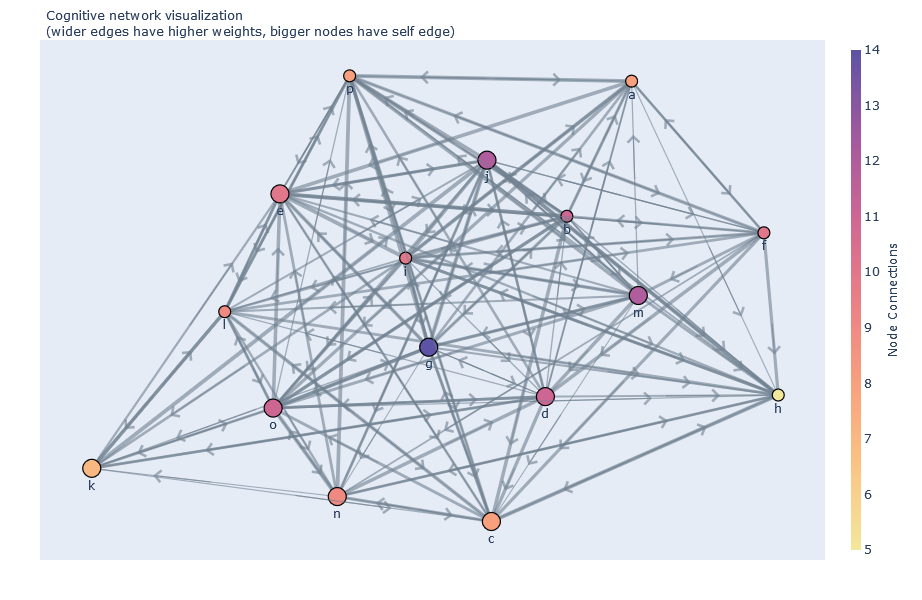

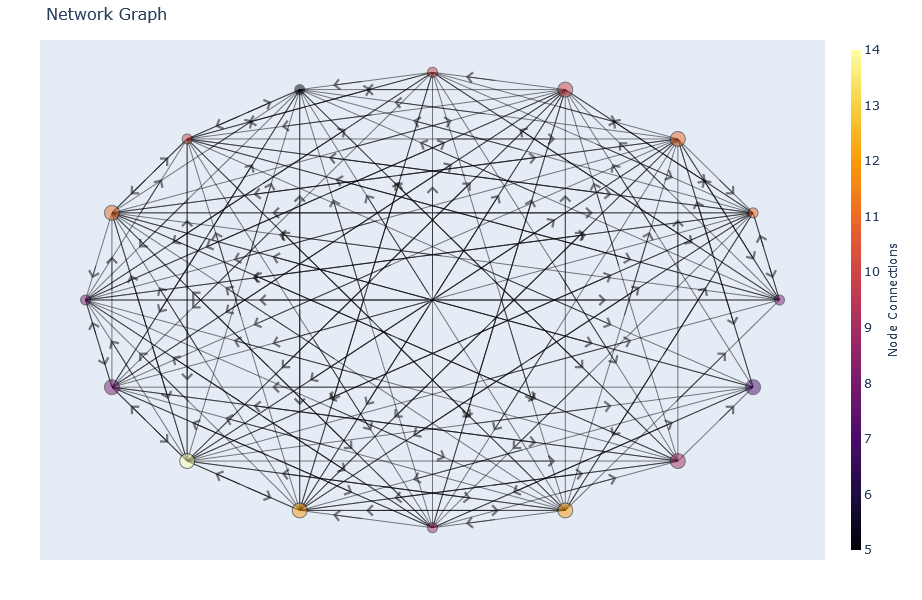

In [8]:
netplot = NetworkXPlotter(example_network, layout="spring")
netplot.plot(
    colorscale="sunset",
    edge_opacity=0.6,
    edge_color="SlateGrey",
    node_opacity=1,
    node_size=12,
    edge_scale=3,
    title = "Cognitive network visualization<br>(wider edges have higher weights, bigger nodes have self edge)",
    fontsize = 12,
    plot_text = True
)
print()
netplot = NetworkXPlotter(example_network, layout="circular")
netplot.plot(save_html=True); # <- saves html sring as a field of object netplot

## PyQt
I belive in `PyQt` we can use something like the following:

In [9]:
plot_widget = QWebEngineView()
plot_widget.setHtml(netplot.html)

NameError: name 'QWebEngineView' is not defined